# Cuaderno para entrenar el modelo de filtrado de lenguaje soez

Este modelo detecta lenguaje ofensivo en textos. Primero se preprocesan los comentarios (normalización, tokenización, eliminación de stopwords y lematización) y se convierten en vectores mediante TF-IDF. 

Luego, un clasificador (como XGBoost) determina si un mensaje es ofensivo o no, evaluando su desempeño con métricas de clasificación.

### 1. Importación de librerías

Comenzaremos por importar las librerías necesarias para el modelo de filtrado.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

### 2. Carga del dataset

Cargaremos a continuación el DataSet desde el link correspondiente, veremos un poco los datos que tenemos.

In [8]:
url = "https://drive.google.com/uc?id=17h8WxwYmOpueXvzvnrGQfbNNaVuYoTCd"
df = pd.read_csv(url)
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Vemos que todos los datos que tenemos son mensajes en inglés, que es con lo que trabajará principalmente el modelo, por esto, este filtro de lenguaje soez que realizaremos funciona principalmente en este idioma.

In [9]:
df.describe

<bound method NDFrame.describe of                       id                                       comment_text  \
0       0000997932d777bf  Explanation\nWhy the edits made under my usern...   
1       000103f0d9cfb60f  D'aww! He matches this background colour I'm s...   
2       000113f07ec002fd  Hey man, I'm really not trying to edit war. It...   
3       0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...   
4       0001d958c54c6e35  You, sir, are my hero. Any chance you remember...   
...                  ...                                                ...   
159566  ffe987279560d7ff  ":::::And for the second time of asking, when ...   
159567  ffea4adeee384e90  You should be ashamed of yourself \n\nThat is ...   
159568  ffee36eab5c267c9  Spitzer \n\nUmm, theres no actual article for ...   
159569  fff125370e4aaaf3  And it looks like it was actually you who put ...   
159570  fff46fc426af1f9a  "\nAnd ... I really don't think you understand...   

        toxic  se

### 3. Tratamiento de datos

Crearemos a continuacion una columna binaria, en la cual agruparemos cualquier tipo de toxicidad en una misma columna, para saber cuales son ofensivas o no. 

In [10]:
df["is_offensive"] = df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].max(axis=1)
df_filtered = df[["comment_text", "is_offensive"]]

Descargaremos el modelo de lenguaje de nltk para tokenización.

In [11]:
nltk.download(['punkt_tab', 'stopwords', 'wordnet'])

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\alfre\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alfre\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alfre\AppData\Roaming\nltk_data...


True

In [12]:
def preprocess_text(text):
    text = text.lower().strip()
    
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', '', text)
    
    tokens = word_tokenize(text)
    
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return ' '.join(tokens)

df_filtered["comment_text"] = df_filtered["comment_text"].apply(preprocess_text)

tfidf_vectorizer = TfidfVectorizer(
    max_features=50000,
    min_df=3,
    max_df=0.95,
    ngram_range=(1, 3),
    strip_accents='unicode'
)

C:\Users\alfre\AppData\Local\Temp\ipykernel_20416\3406227079.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["comment_text"] = df_filtered["comment_text"].apply(preprocess_text)


### 4. Entrenamiento del modelo

Entrenaremos el modelo de filtrado de mensajes a continuación:

In [13]:
def prepare_training_data(df):

    X = df["comment_text"].apply(preprocess_text)
    
    y = df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].max(axis=1)
    
    vectorizer = TfidfVectorizer(
        max_features=50000,
        min_df=3,
        max_df=0.95,
        ngram_range=(1, 3)
    )
    
    X_vectorized = vectorizer.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_vectorized, 
        y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )
    
    return X_train, X_test, y_train, y_test, vectorizer


In [14]:
X_train, X_test, y_train, y_test, vectorizer = prepare_training_data(df)

model = XGBClassifier(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    use_label_encoder=False,
    eval_metric='logloss'
)

model.fit(X_train, y_train)

d:\CEIABD\TFM\MentorAI\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:06:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

### 5. Pruebas y guardado 

Para finalizar guardaremos nuestro modelo, de esta forma podremos usarlo posteriormente en nuestra aplicación para filtrar los mensajes antes de hacer la petición a la API de ChatGPT.

In [22]:
y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     28670
           1       0.94      0.50      0.65      3245

    accuracy                           0.95     31915
   macro avg       0.94      0.75      0.81     31915
weighted avg       0.95      0.95      0.94     31915



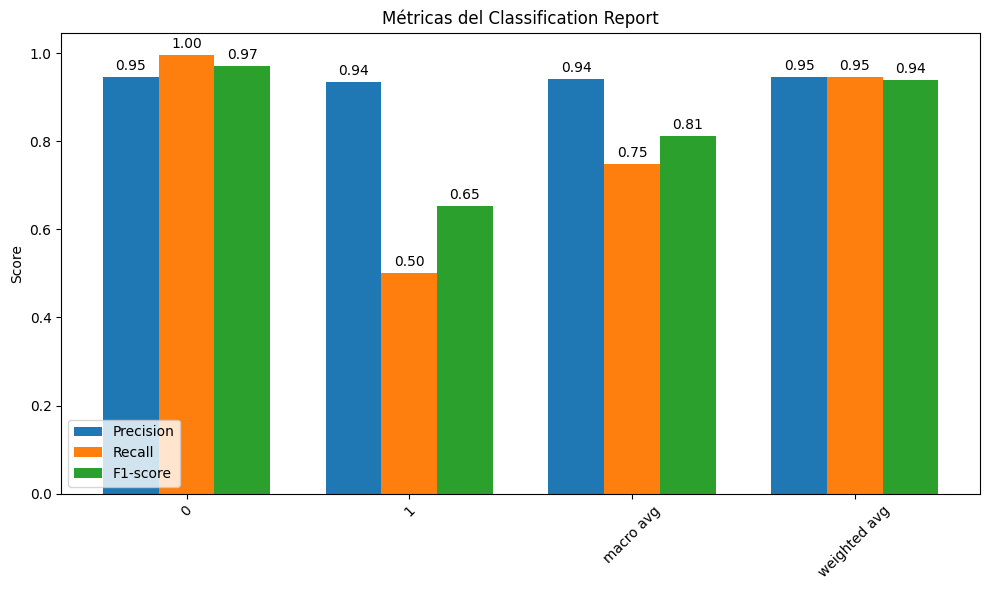

In [23]:
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()

data = df_report.iloc[:-1, :].T.values
x_labels = df_report.iloc[:-1, :].T.columns
y_labels = df_report.iloc[:-1, :].T.index

metrics = df_report.drop(columns=["support"], errors='ignore')
if "accuracy" in metrics.index:
    metrics = metrics.drop(index="accuracy")

classes = metrics.index
x = np.arange(len(classes))
width = 0.25  # ancho de cada barra

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width, metrics["precision"], width, label="Precision")
bars2 = ax.bar(x, metrics["recall"], width, label="Recall")
bars3 = ax.bar(x + width, metrics["f1-score"], width, label="F1-score")

# Añadimos los valores encima de cada barra
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # desplazamiento vertical
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)

ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=45)
ax.set_ylabel("Score")
ax.set_title("Métricas del Classification Report")
ax.legend()

plt.tight_layout()
plt.show()

Con el siguiente codigo exportaremos en un archivo `.joblib` el modelo creado, de esta forma tendremos el modelo para poder filtrar lenguaje soez en inglés.

In [ ]:
joblib.dump({
    'model': model,
    'vectorizer': vectorizer
}, 'toxic_classifier.joblib')

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     28670
           1       0.94      0.50      0.65      3245

    accuracy                           0.95     31915
   macro avg       0.94      0.75      0.81     31915
weighted avg       0.95      0.95      0.94     31915

